In [1]:
# DEPENDÊNCIAS
!pip install pandas numpy matplotlib seaborn scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)



In [2]:
# UPLOAD E LEITURA DOS ARQUIVOS OFICIAIS
from google.colab import files
uploaded = files.upload()  # selecione UNSW_NB15_training-set.csv e UNSW_NB15_testing-set.csv

train_name = [n for n in uploaded if "train" in n.lower()][0]
test_name  = [n for n in uploaded if "test"  in n.lower()][0]

train = pd.read_csv(train_name)
test  = pd.read_csv(test_name)

print("train:", train.shape, "test:", test.shape)


Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv
Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
train: (175341, 45) test: (82332, 45)


In [3]:
def health_check(df, label_col='label', attack_col='attack_cat'):
    print("Dimensões:", df.shape)
    print("\nTipos (top 10):"); print(df.dtypes.value_counts().head(10))
    nz = df.isnull().sum()
    nz = nz[nz>0].sort_values(ascending=False)
    print("\nNulos (top 15):"); print(nz.head(15) if len(nz) else "Sem nulos.")
    if label_col in df.columns:
        print("\nDistribuição label (0 normal / 1 ataque):")
        print(df[label_col].value_counts(dropna=False))
    if attack_col in df.columns:
        print("\nTop categorias de ataque:"); print(df[attack_col].value_counts().head(12))
    print("\nDuplicatas:", df.duplicated().sum())

print("=== TRAIN ==="); health_check(train)
print("\n=== TEST ==="); health_check(test)


=== TRAIN ===
Dimensões: (175341, 45)

Tipos (top 10):
int64      30
float64    11
object      4
Name: count, dtype: int64

Nulos (top 15):
Sem nulos.

Distribuição label (0 normal / 1 ataque):
label
1    119341
0     56000
Name: count, dtype: int64

Top categorias de ataque:
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Duplicatas: 0

=== TEST ===
Dimensões: (82332, 45)

Tipos (top 10):
int64      30
float64    11
object      4
Name: count, dtype: int64

Nulos (top 15):
Sem nulos.

Distribuição label (0 normal / 1 ataque):
label
1    45332
0    37000
Name: count, dtype: int64

Top categorias de ataque:
attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
An

In [4]:
def clean_and_engineer(df):
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()

    # rótulo binário
    df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(0).astype(int)
    df['label_text'] = np.where(df['label'] == 1, 'attack', 'normal')

    # numéricos principais
    for c in ['sbytes','dbytes','spkts','dpkts','dur']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # atributos derivados
    if {'sbytes','dbytes'}.issubset(df.columns):
        df['bytes_total'] = df['sbytes'].fillna(0) + df['dbytes'].fillna(0)
        df['bytes_ratio'] = df['sbytes'].fillna(0) / (df['dbytes'].fillna(0) + 1)

    if {'spkts','dpkts'}.issubset(df.columns):
        df['pkts_total'] = df['spkts'].fillna(0) + df['dpkts'].fillna(0)

    if 'dur' in df.columns:
        df['log_dur'] = np.log1p(df['dur'].clip(lower=0))

    return df

train = clean_and_engineer(train)
test  = clean_and_engineer(test)

print("colunas (amostra):", list(train.columns)[:20])


colunas (amostra): ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit']


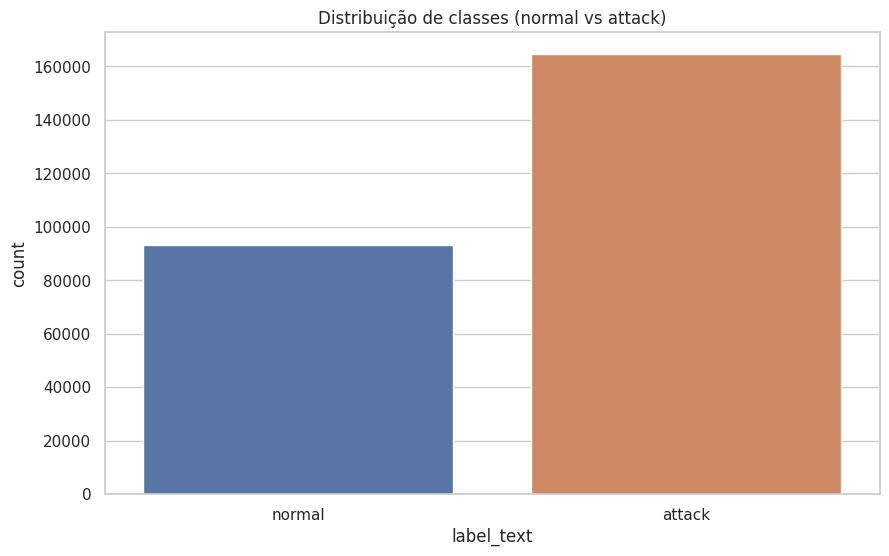

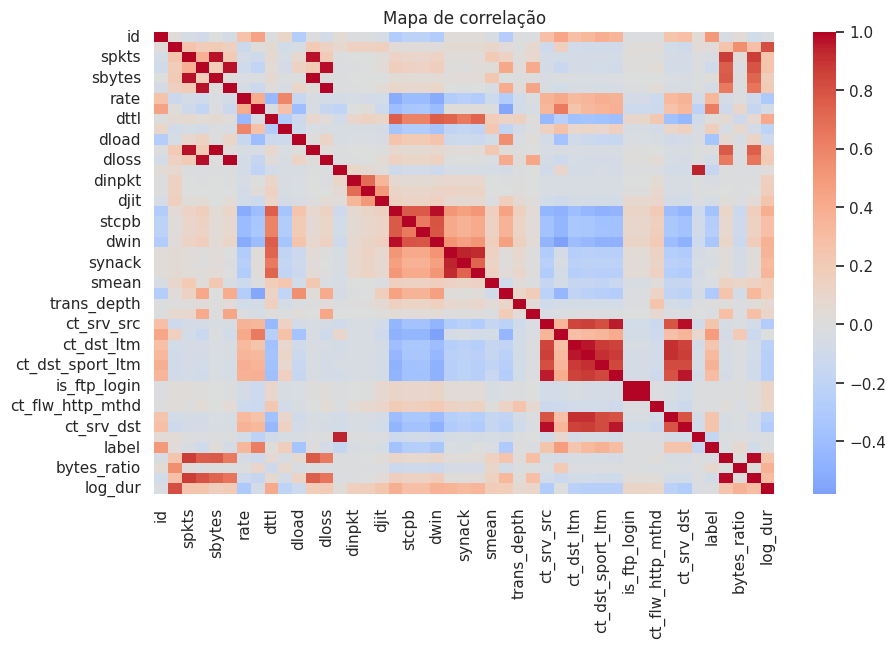

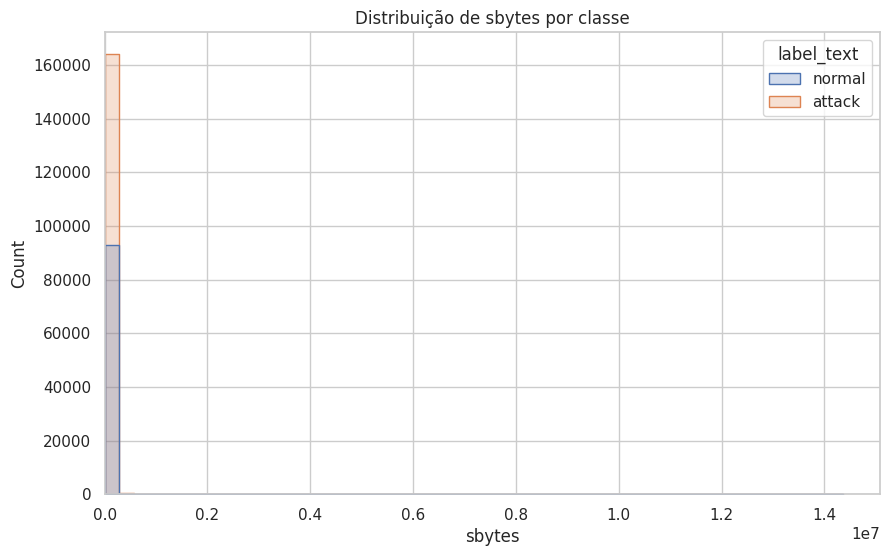

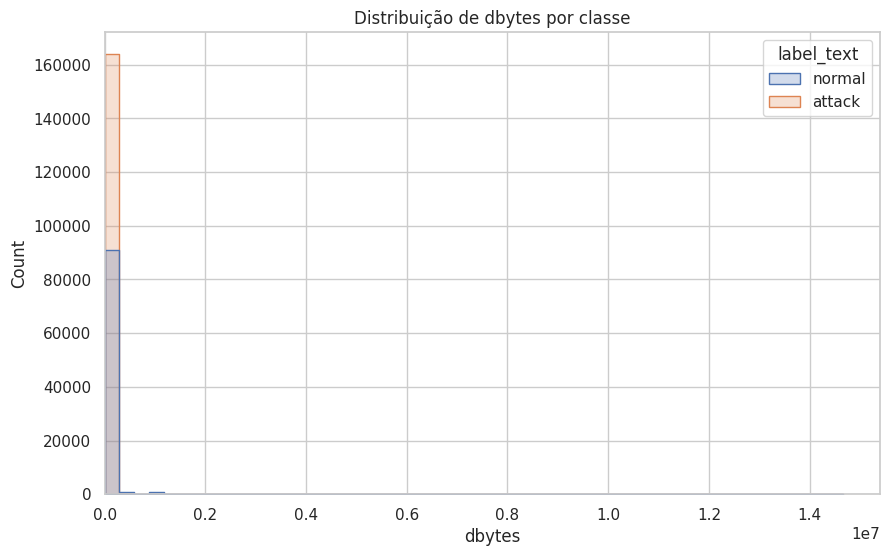

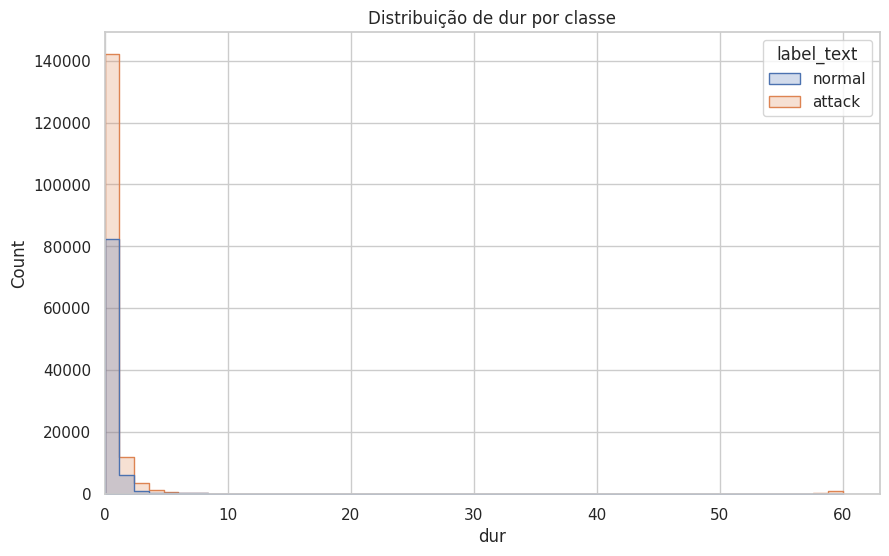

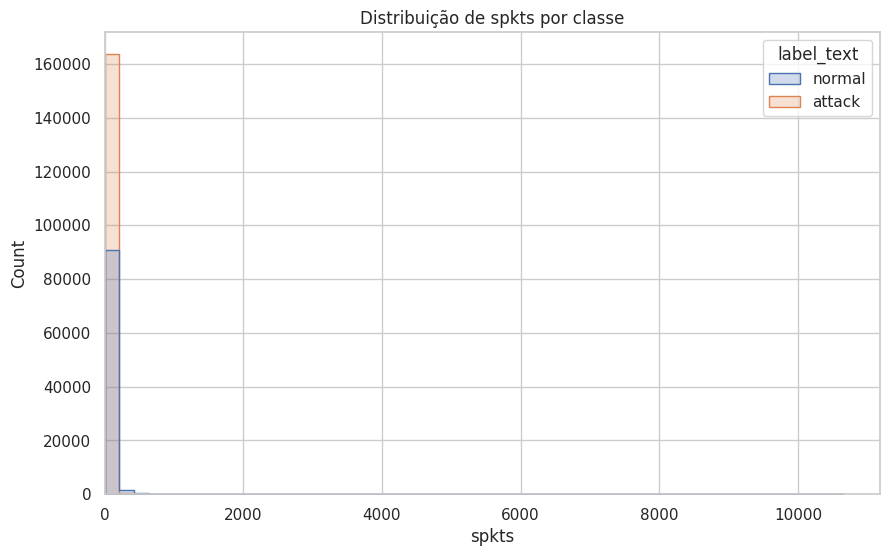

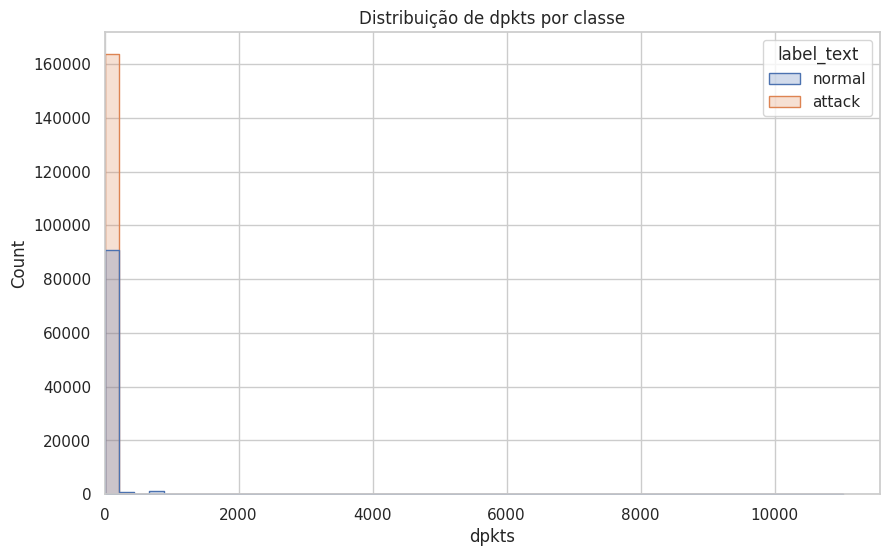

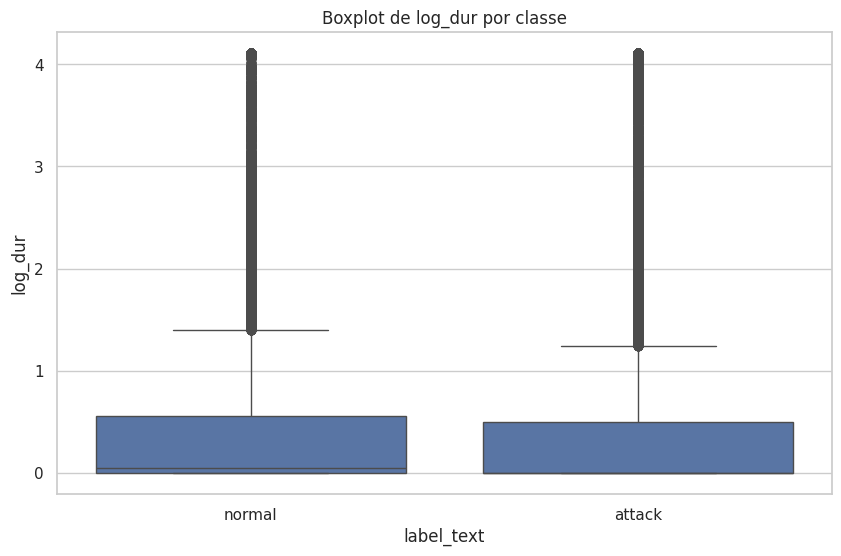

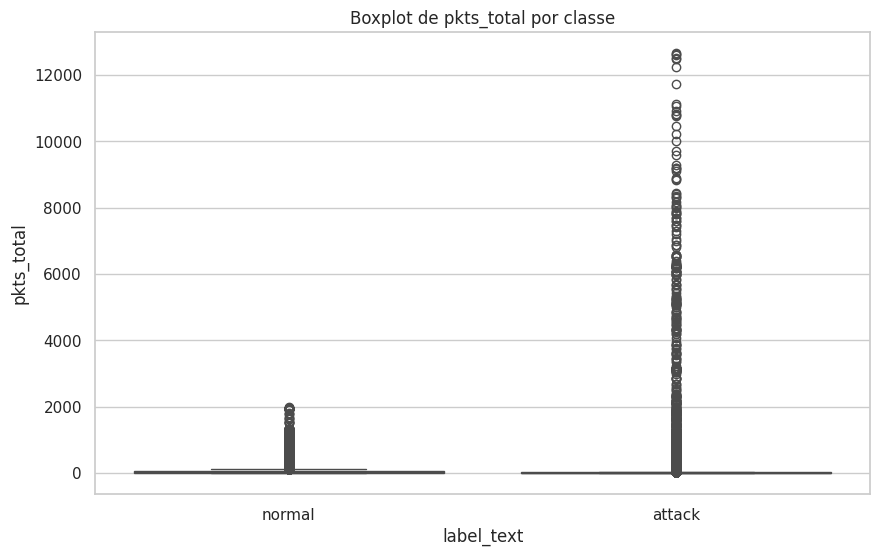

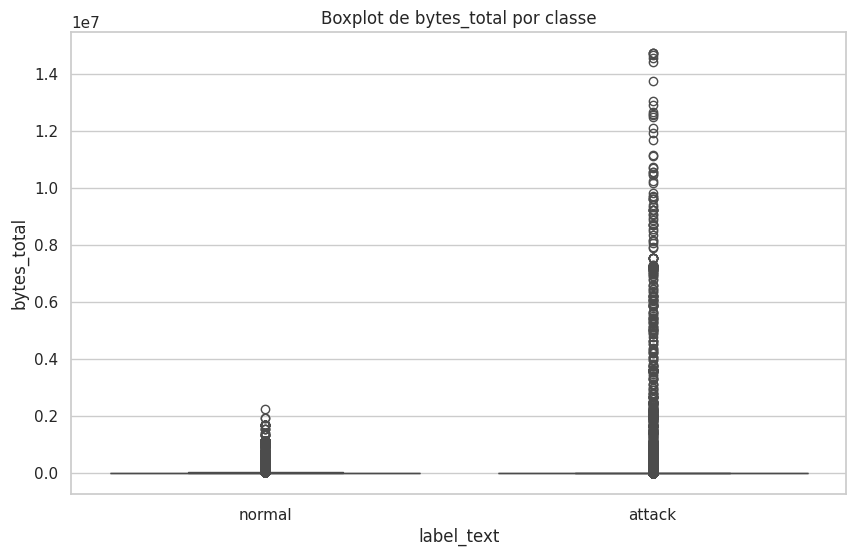

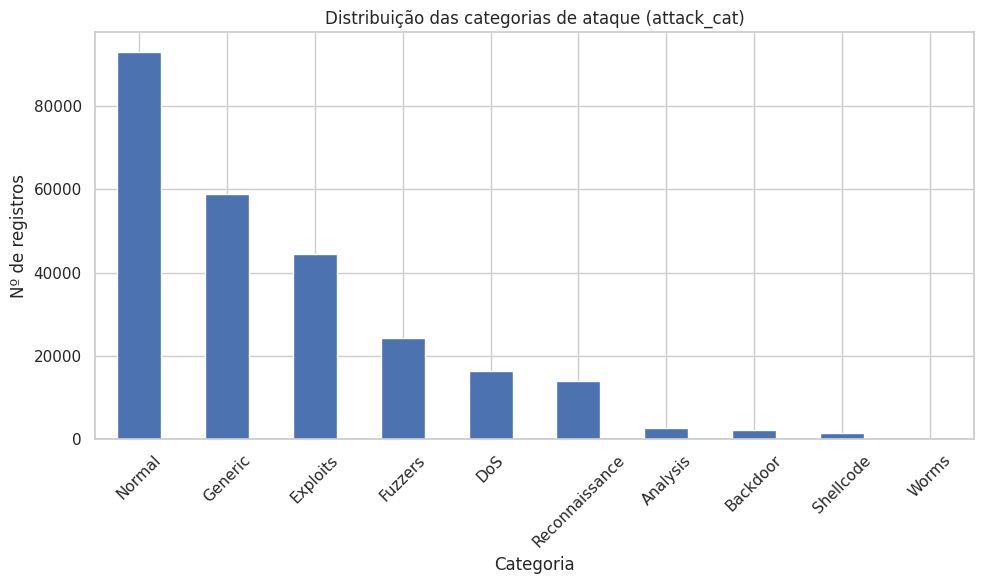

In [5]:
# CONJUNTO COMPLETO apenas para EDA/plots
df = pd.concat([train, test], ignore_index=True)

# 1) Distribuição de classes
sns.countplot(data=df, x="label_text", hue="label_text", legend=False)
plt.title("Distribuição de classes (normal vs attack)")
plt.savefig("f1.png", dpi=300, bbox_inches="tight"); plt.show()

# 2) Mapa de correlação (numéricas)
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Mapa de correlação")
plt.savefig("f3.png", dpi=300, bbox_inches="tight"); plt.show()

# 3) Histogramas por classe
for col, fname in [
    ("sbytes", "f7.png"),
    ("dbytes", "f6.png"),
    ("dur", "f5.png"),
    ("spkts", "f9.png"),
    ("dpkts", "f10.png"),
]:
    if col in df.columns:
        sns.histplot(data=df, x=col, hue="label_text", bins=50, element="step", stat="count")
        plt.title(f"Distribuição de {col} por classe")
        plt.xlim(left=0)
        plt.savefig(fname, dpi=300, bbox_inches="tight"); plt.show()

# 4) Boxplots
for col, fname in [
    ("log_dur", "f11.png"),
    ("pkts_total", "f12.png"),
    ("bytes_total", "f13.png"),
]:
    if col in df.columns:
        sns.boxplot(data=df, x="label_text", y=col)
        plt.title(f"Boxplot de {col} por classe")
        plt.savefig(fname, dpi=300, bbox_inches="tight"); plt.show()

# 5) Distribuição das categorias de ataque (Figura 17)
if 'attack_cat' in df.columns:
    ax = df['attack_cat'].value_counts().plot(kind='bar')
    plt.title("Distribuição das categorias de ataque (attack_cat)")
    plt.ylabel("Nº de registros"); plt.xlabel("Categoria")
    plt.xticks(rotation=45); plt.tight_layout()
    plt.savefig("ultima.png", dpi=300, bbox_inches="tight"); plt.show()


              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     37000
      attack       1.00      1.00      1.00     45332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332

ROC-AUC (RF): 1.0


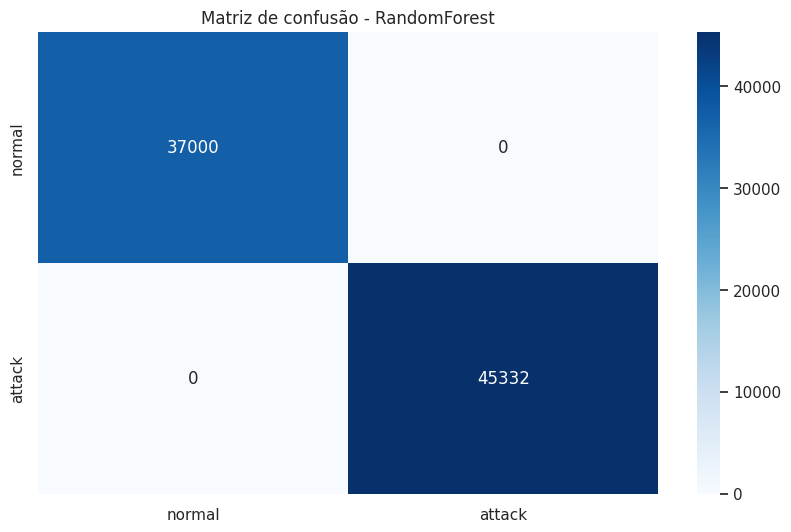

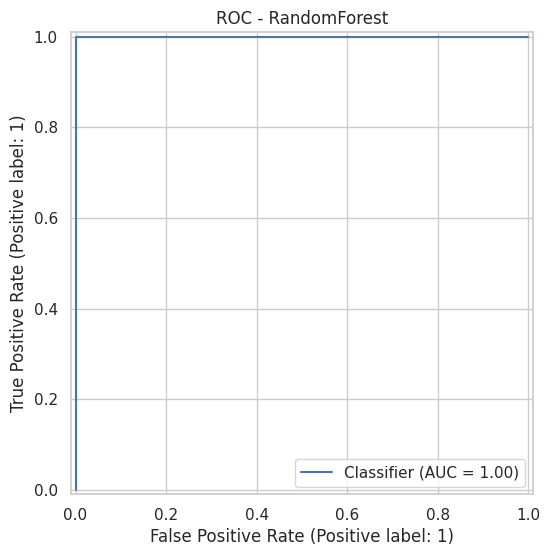

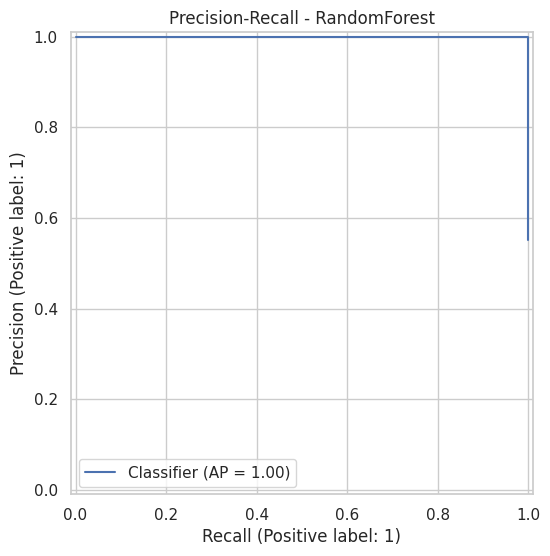

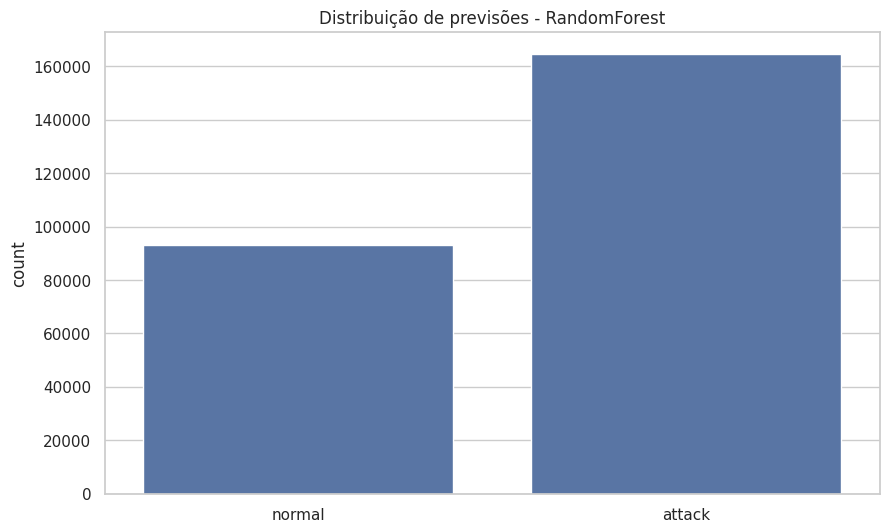

In [6]:
# SEPARAR X/y SEM VAZAMENTO
drop_cols = {'label','label_text','srcip','dstip','stime','ltime'}
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_test  = test.drop(columns=[c for c in drop_cols if c in test.columns])
y_train = train['label'].values
y_test  = test['label'].values

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

rf = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
)
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])
pipe_rf.fit(X_train, y_train)

y_pred  = pipe_rf.predict(X_test)
y_proba = pipe_rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, target_names=["normal","attack"]))
print("ROC-AUC (RF):", roc_auc_score(y_test, y_proba))

# Matriz de confusão (Figura 11)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["normal","attack"], yticklabels=["normal","attack"])
plt.title("Matriz de confusão - RandomForest")
plt.savefig("f4.png", dpi=300, bbox_inches="tight"); plt.show()

# ROC (Figura 12)
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC - RandomForest")
plt.savefig("f2.png", dpi=300, bbox_inches="tight"); plt.show()

# Precision-Recall (Figura 13)
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall - RandomForest")
plt.savefig("f8.png", dpi=300, bbox_inches="tight"); plt.show()

# Distribuição de previsões (Figura 14)
rf_pred_all = pipe_rf.predict(pd.concat([X_train, X_test], ignore_index=True))
sns.countplot(x=rf_pred_all)
plt.xticks([0,1], ["normal","attack"])
plt.title("Distribuição de previsões - RandomForest")
plt.savefig("f14.png", dpi=300, bbox_inches="tight"); plt.show()


Distribuição antes do SMOTE: [ 56000 119341]
Distribuição depois do SMOTE: [119341 119341]

=== Random Forest + SMOTE ===
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     37000
      attack       1.00      1.00      1.00     45332

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332

ROC-AUC (RF + SMOTE): 1.0


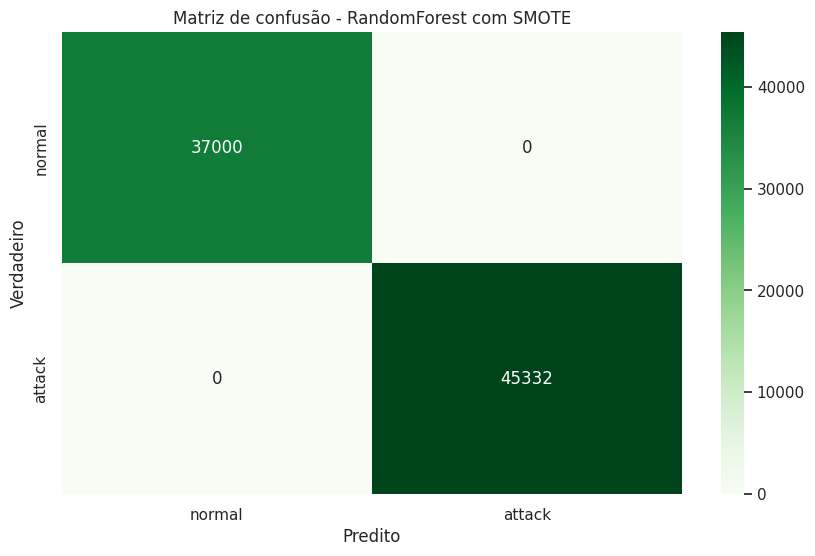

In [9]:
# --- BALANCEAMENTO DE CLASSES COM SMOTE

# 1) Instalação
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn --quiet
    from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2) Recria PREPROCESSADOR compatível com SMOTE (OneHotEncoder denso)
#    (algumas versões usam 'sparse_output', outras 'sparse'; o try/except garante compatibilidade)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre_bal = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", enc,              cat_cols)
])

# 3) Transforma treino/teste com o mesmo preprocessor
X_train_enc = pre_bal.fit_transform(X_train)
X_test_enc  = pre_bal.transform(X_test)

# 4) Aplica SMOTE SOMENTE no treino
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train)

print("Distribuição antes do SMOTE:", np.bincount(y_train))
print("Distribuição depois do SMOTE:", np.bincount(y_train_sm))

# 5) Treina RF nos dados balanceados
rf_sm = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    # você já usava class_weight; com SMOTE pode manter 'balanced_subsample' ou None.
    class_weight=None
)
rf_sm.fit(X_train_sm, y_train_sm)

# 6) Avaliação no conjunto de teste (NÃO balanceado)
y_pred_sm  = rf_sm.predict(X_test_enc)
# Para ROC-AUC, precisamos de probabilidades da classe "1"
if hasattr(rf_sm, "predict_proba"):
    y_proba_sm = rf_sm.predict_proba(X_test_enc)[:, 1]
else:
    # fallback: usa frequência das árvores
    y_proba_sm = np.mean([estimator.predict_proba(X_test_enc)[:,1] for estimator in rf_sm.estimators_], axis=0)

print("\n=== Random Forest + SMOTE ===")
print(classification_report(y_test, y_pred_sm, target_names=["normal","attack"]))
print("ROC-AUC (RF + SMOTE):", roc_auc_score(y_test, y_proba_sm))

# 7) Matriz de confusão e figura
cm_sm = confusion_matrix(y_test, y_pred_sm)
ax = sns.heatmap(cm_sm, annot=True, fmt="d", cmap="Greens",
                 xticklabels=["normal","attack"], yticklabels=["normal","attack"])
ax.set_title("Matriz de confusão - RandomForest com SMOTE")
plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
plt.savefig("f_rf_smote.png", dpi=300, bbox_inches="tight"); plt.show()


Isolation Forest
              precision    recall  f1-score   support

      normal       0.44      0.94      0.60     23250
      attack       0.90      0.32      0.47     41169

    accuracy                           0.54     64419
   macro avg       0.67      0.63      0.53     64419
weighted avg       0.73      0.54      0.52     64419

ROC-AUC (IF): 0.20096111569489206


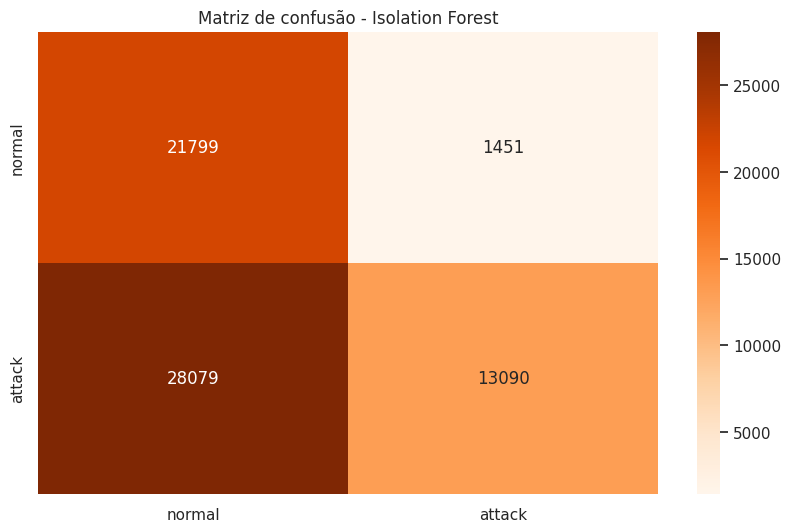

In [7]:
# DADOS NUMÉRICOS PARA IF/OCSVM
num_cols_all = df.select_dtypes(include=[np.number]).columns
X_num = df[num_cols_all].fillna(0)

# Split consistente para avaliação (estratificado)
from sklearn.model_selection import train_test_split
Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_num, df['label'].values, test_size=0.25, random_state=42, stratify=df['label'].values
)

# Treinar IF só com NORMAL no treino
mask_normal = (yn_train == 0)
scaler_iso = StandardScaler()
Xn_train_norm = scaler_iso.fit_transform(Xn_train[mask_normal])
Xn_test_scaled = scaler_iso.transform(Xn_test)

iso = IsolationForest(n_estimators=300, contamination="auto", random_state=42)
iso.fit(Xn_train_norm)

# Scores e predições
y_score_if = iso.decision_function(Xn_test_scaled)       # para ROC-AUC
pred_if = iso.predict(Xn_test_scaled)                    # -1 anomalia, 1 normal
pred_if = np.where(pred_if == -1, 1, 0)                  # 1=attack, 0=normal

print("Isolation Forest")
print(classification_report(yn_test, pred_if, target_names=["normal","attack"]))
print("ROC-AUC (IF):", roc_auc_score(yn_test, y_score_if))

cm = confusion_matrix(yn_test, pred_if)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["normal","attack"], yticklabels=["normal","attack"])
plt.title("Matriz de confusão - Isolation Forest")
plt.savefig("f15.png", dpi=300, bbox_inches="tight"); plt.show()


One-Class SVM
              precision    recall  f1-score   support

      normal       0.49      0.95      0.64     23250
      attack       0.94      0.44      0.60     41169

    accuracy                           0.62     64419
   macro avg       0.71      0.69      0.62     64419
weighted avg       0.77      0.62      0.62     64419



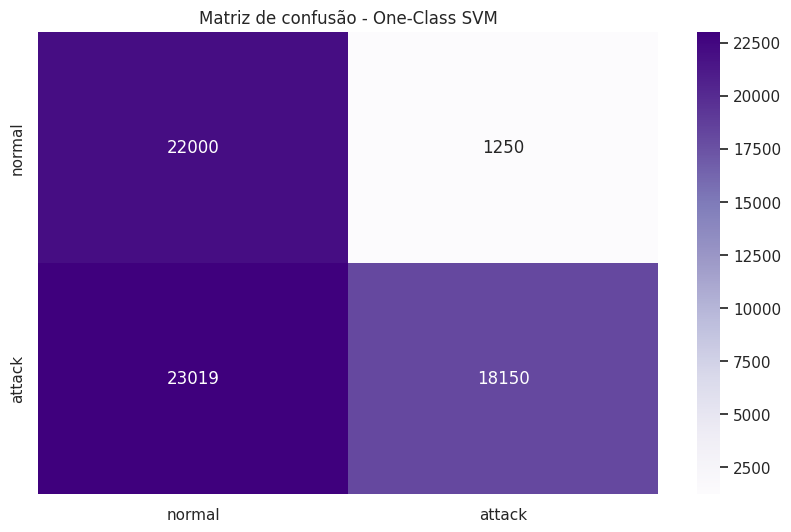

In [8]:
ocs = OneClassSVM(kernel="rbf", gamma="auto", nu=0.05)
ocs.fit(Xn_train_norm)

pred_ocs = ocs.predict(Xn_test_scaled)
pred_ocs = np.where(pred_ocs == -1, 1, 0)

print("One-Class SVM")
print(classification_report(yn_test, pred_ocs, target_names=["normal","attack"]))

cm = confusion_matrix(yn_test, pred_ocs)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["normal","attack"], yticklabels=["normal","attack"])
plt.title("Matriz de confusão - One-Class SVM")
plt.savefig("f16.png", dpi=300, bbox_inches="tight"); plt.show()


##  Comparação de Modelos — Detecção de Anomalias (UNSW-NB15)

| Modelo                 | Classe  | Precision | Recall | F1-score | Support |
|------------------------|---------|-----------|--------|-----------|----------|
| **Random Forest**      | Normal  | 1.00      | 1.00   | 1.00      | 37 000   |
|                        | Attack  | 1.00      | 1.00   | 1.00      | 45 332   |
|                        | **Acurácia** | — | — | **1.00** | 82 332 |
|                        | **ROC-AUC**  | — | — | — | **1.00** |
| **Random Forest + SMOTE** | Normal  | 1.00      | 1.00   | 1.00      | 37 000   |
|                        | Attack  | 1.00      | 1.00   | 1.00      | 45 332   |
|                        | **Acurácia** | — | — | **1.00** | 82 332 |
|                        | **ROC-AUC**  | — | — | — | **1.00** |
| **Isolation Forest**   | Normal  | 0.44      | 0.94   | 0.60      | 23 250   |
|                        | Attack  | 0.90      | 0.32   | 0.47      | 41 169   |
|                        | **Acurácia** | — | — | **0.54** | 64 419 |
|                        | **ROC-AUC**  | — | — | — | **0.20** |
| **One-Class SVM**      | Normal  | 0.49      | 0.95   | 0.64      | 23 250   |
|                        | Attack  | 0.94      | 0.44   | 0.60      | 41 169   |
|                        | **Acurácia** | — | — | **0.62** | 64 419 |
|                        | **ROC-AUC**  | — | — | — | (não calculado) |

---

###  Insights
- O **Random Forest** supervisionado (com e sem SMOTE) obteve desempenho **perfeito** neste dataset (Acurácia e ROC-AUC = 1.0).  
- O **SMOTE** não trouxe melhoria porque o modelo já performava de forma ótima.  
- O **Isolation Forest** apresentou recall alto para “normal”, mas recall baixo para “ataque”, com ROC-AUC = 0.20.  
- O **One-Class SVM** teve desempenho melhor que o IF, mas ainda bem inferior ao RF (acurácia = 0.62).  
